Epoch 1/20
5127/5127 - 50s - 10ms/step - loss: 2760.5183 - month_loss: 922.8828 - season_loss: 917.6431 - val_loss: 601.8394 - val_month_loss: 199.9360 - val_season_loss: 202.2908 - val_week_loss: 200.5538 - week_loss: 919.8661
Epoch 2/20
5127/5127 - 46s - 9ms/step - loss: 1775.6089 - month_loss: 590.3926 - season_loss: 600.8898 - val_loss: 630.7645 - val_month_loss: 209.7977 - val_season_loss: 211.2708 - val_week_loss: 210.5818 - week_loss: 584.2507
Epoch 3/20
5127/5127 - 44s - 9ms/step - loss: 1668.1085 - month_loss: 555.1396 - season_loss: 566.5144 - val_loss: 594.2808 - val_month_loss: 197.5013 - val_season_loss: 199.9068 - val_week_loss: 197.8011 - week_loss: 546.4619
Epoch 4/20
5127/5127 - 44s - 9ms/step - loss: 1652.0582 - month_loss: 549.8418 - season_loss: 561.3282 - val_loss: 626.7258 - val_month_loss: 208.4351 - val_season_loss: 210.3491 - val_week_loss: 208.8552 - week_loss: 540.8191
Epoch 5/20
5127/5127 - 45s - 9ms/step - loss: 1666.7314 - month_loss: 554.7780 - season_los

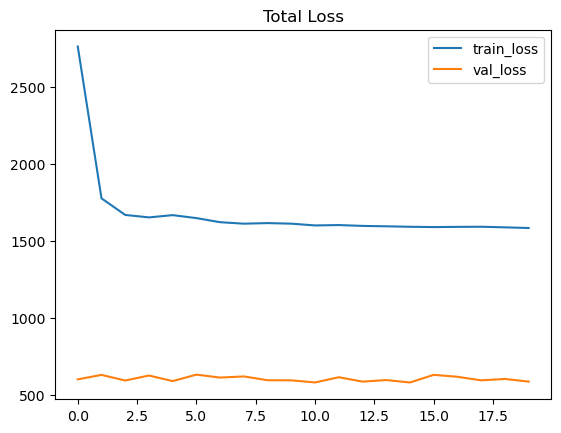


Validation Metrics: {'loss': 587.1009521484375, 'month_loss': 194.59219360351562, 'season_loss': 197.339111328125, 'week_loss': 196.11727905273438}
1302/1302 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Overall Season MSE: 197.090


In [3]:
import tensorflow as tf
# Clear previous models/graphs
tf.keras.backend.clear_session()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


def load_data(file_path='data/data_for_modeling.csv'):
    df = pd.read_csv(file_path, parse_dates=['date'])
    df.set_index('date', inplace=True)
    return df[['unique_id', 'units']]


def create_multitask_sequences(data, window, w_h, m_h, s_h):
    """
    Generate sliding windows and future targets from a 1D array `data`.
    """
    X_list, y_w, y_m, y_s = [], [], [], []
    n = len(data)
    for i in range(n - window - s_h + 1):
        seq = data[i:i+window]
        fut = data[i+window:i+window+s_h]
        X_list.append(seq)
        y_w.append(fut[:w_h])
        y_m.append(fut[:m_h])
        y_s.append(fut)
    X = np.stack(X_list)[..., None]
    return X, np.stack(y_w), np.stack(y_m), np.stack(y_s)


def build_dataset_and_holdouts(df, window, season_horizon, month_horizon, week_horizon):
    """
    For each unique_id series, split off its last horizons as holdouts,
    but here we only return training sequences (no in-function validation).
    """
    X_list, yw_list, ym_list, ys_list = [], [], [], []
    for uid, group in df.groupby('unique_id'):
        series = group['units'].sort_index().values
        train_data = series
        if len(train_data) < window + season_horizon:
            continue
        X, yw, ym, ys = create_multitask_sequences(
            train_data, window, week_horizon, month_horizon, season_horizon
        )
        X_list.append(X)
        yw_list.append(yw)
        ym_list.append(ym)
        ys_list.append(ys)
    X_all = np.concatenate(X_list, axis=0)
    y_w_all = np.concatenate(yw_list, axis=0)
    y_m_all = np.concatenate(ym_list, axis=0)
    y_s_all = np.concatenate(ys_list, axis=0)
    return X_all, {'week': y_w_all, 'month': y_m_all, 'season': y_s_all}


def build_multihead_model(window, week_horizon, month_horizon, season_horizon,
                          lstm_units=50, dropout_rate=0.1):
    inp = Input(shape=(window, 1), name='input')
    x = LSTM(
        lstm_units,
        activation='tanh',
        dropout=dropout_rate,
        recurrent_dropout=dropout_rate,
        name='lstm'
    )(inp)
    x = Dropout(dropout_rate, name='dropout')(x)
    out_w = Dense(week_horizon, name='week')(x)
    out_m = Dense(month_horizon, name='month')(x)
    out_s = Dense(season_horizon, name='season')(x)
    model = Model(inputs=inp, outputs=[out_w, out_m, out_s], name='multitask_lstm_dropout')
    model.compile(
        optimizer='adam',
        loss={'week': 'mse', 'month': 'mse', 'season': 'mse'},
        loss_weights={'week': 1.0, 'month': 1.0, 'season': 1.0}
    )
    return model


if __name__=='__main__':
    # Load data and parameters
    df = load_data()
    window, w_h, m_h, s_h = 30, 7, 30, 90

    # Split unique_ids into train/validation groups
    all_ids = df['unique_id'].unique()
    train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

    # Build training set: all sequences from train_ids
    X_train, y_train = build_dataset_and_holdouts(
        df[df['unique_id'].isin(train_ids)],
        window, s_h, m_h, w_h
    )

    # Build validation set: sequences from val_ids
    X_val, y_val = build_dataset_and_holdouts(
        df[df['unique_id'].isin(val_ids)],
        window, s_h, m_h, w_h
    )

    # Build and train model with real hold-out
    model = build_multihead_model(window, w_h, m_h, s_h, dropout_rate=0.1)
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=32,
        validation_data=(X_val, y_val),
        verbose=2
    )

    # Plot train/validation loss
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title('Total Loss'); plt.legend(); plt.show()

    # Final evaluation on validation set
    val_metrics = model.evaluate(X_val, y_val, verbose=0, return_dict=True)
    print("\nValidation Metrics:", val_metrics)
    # Compute per-series season MSE if desired
    preds = model.predict(X_val)[2]
    season_mse = mean_squared_error(y_val['season'], preds)
    print(f"Overall Season MSE: {season_mse:.3f}")
